<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Yannick/AML_IceCores_NN_load_model_UMAP_Peruvian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! gdown --id 1FkB-wMHYzgK74-pek2H33DIpmfSOIxWc  # copy this line for peru data
#! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
from Models import make_autoencoder, make_NN
! gdown --id 1vmtn2HUFFspLehTO-9HNCnphSdiZGez3
! gdown --id 1vOWLDeQh2EEyH2J3VH5XZHhTLqMqAjkV
! gdown --id 1fv_xxclDQrccHZ-T00-cVYHIMFaYjklA
! gdown --id 1NATGxPWVYS71Y-dwPZQvrE7BdsoSpVP8
! unzip autoencoder_128.zip
! unzip encoder_128.zip
! unzip Peru_data.zip                           # copy this line for peru data
! unzip NN_scalar_encoder_128.zip
! unzip NN_last_layer_scalar_encoder_128.zip
!pip install pyyaml h5py 
!pip install umap-learn
!pip install bayesian-optimization

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: images/QCY/QCY_27_2_5_293.png  
 extracting: images/QCY/QCY_27_2_5_294.png  
 extracting: images/QCY/QCY_27_2_5_295.png  
 extracting: images/QCY/QCY_27_2_5_296.png  
 extracting: images/QCY/QCY_27_2_5_297.png  
 extracting: images/QCY/QCY_27_2_5_298.png  
 extracting: images/QCY/QCY_27_2_5_299.png  
 extracting: images/QCY/QCY_27_2_5_3.png  
 extracting: images/QCY/QCY_27_2_5_30.png  
  inflating: images/QCY/QCY_27_2_5_300.png  
 extracting: images/QCY/QCY_27_2_5_301.png  
 extracting: images/QCY/QCY_27_2_5_302.png  
 extracting: images/QCY/QCY_27_2_5_303.png  
 extracting: images/QCY/QCY_27_2_5_304.png  
  inflating: images/QCY/QCY_27_2_5_305.png  
  inflating: images/QCY/QCY_27_2_5_306.png  
  inflating: images/QCY/QCY_27_2_5_307.png  
 extracting: images/QCY/QCY_27_2_5_308.png  
  inflating: images/QCY/QCY_27_2_5_309.png  
 extracting: images/QCY/QCY_27_2_5_31.png  
 extracting: images/QCY/QCY_27_2_5_31

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

In [3]:
# copy this cell for peru data
peru_path = '/content/QCY.csv'
peru_im_path = '/content/images/QCY/'
peru_df = pd.read_csv(peru_path)
peru = not_training_set(peru_df, peru_im_path)

In [4]:
# save image_size
im_e, _ = peru.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [13]:
encoder = keras.models.load_model('encoder_128')

In [5]:
NN = keras.models.load_model('NN_scalar_encoder_128/NN_scalar_encoder_128')
NN_last_layer = keras.models.load_model('NN_last_layer_scalar_encoder_128')

In [8]:
peru_size = len(peru.imgpaths)
peru_size

102764

In [15]:
increment = 5000
nr_its = peru_size//increment
points_left_over = peru_size % increment

list_of_encoded_images = []
x_peru_feats = []
image_count = 0
for i in range(nr_its):
  x_peru = []
  for j in range(increment):
      im, feat = peru.__getitem__(image_count)
      image_count += 1
      x_peru.append(im)
      x_peru_feats.append(feat)
  x_peru = np.array(x_peru)

  encoded = encoder.predict(x_peru)

  list_of_encoded_images.extend(encoded)

x_peru = []
for i in range(points_left_over):
  im, lfeat = peru.__getitem__(image_count)
  image_count += 1
  x_peru.append(im)
  x_peru_feats.append(feat)
x_peru = np.array(x_peru)

encoded = encoder.predict(x_peru)

list_of_encoded_images.extend(encoded)

list_of_encoded_images = np.array(list_of_encoded_images)

x_peru = []
for i in range(len(list_of_encoded_images)):
  one = np.append(x_peru_feats[i], list_of_encoded_images[i])
  x_peru.append(one)

x_peru = np.array(x_peru)

In [17]:
x_peru.shape

(102764, 162)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


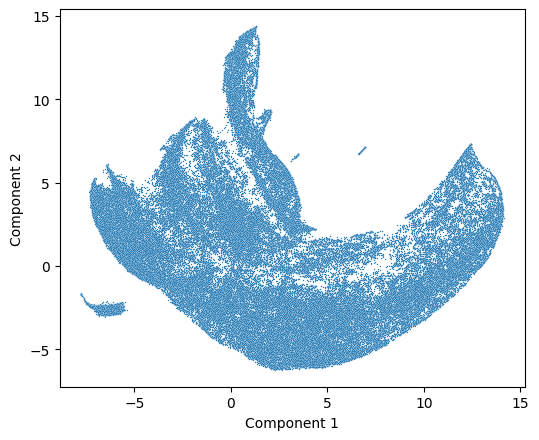

In [16]:
map = umap.UMAP(n_components=2, n_neighbors=40)
last_hidden_vals = NN_last_layer.predict(x_peru)
y = map.fit_transform(last_hidden_vals)

fig, ax = plt.subplots(1, figsize=(6, 5), dpi=100)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

sb.scatterplot(y[:, 0], y[:, 1], s=1.0)#, hue=NN_last_layer.predict(test))
plt.show()

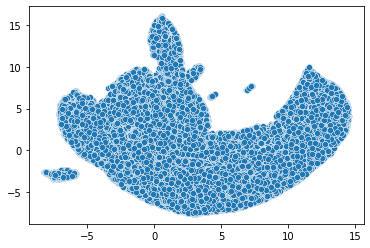

In [18]:
preds = NN.predict(x_peru)
